In [92]:
import pickle
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
# Load the dataset
file_path = "/content/smart_app_data.pkl"
historical_data = pd.read_pickle(file_path)

In [93]:
def extract_features(kpi_name, kpi_value, machine_name, data):

  # function that is able to extract time series filtering for:
  # kpi_vame = name of the kpi
  # kpi_value = which should be chose in the list ['avg', 'sum', 'min', 'max']
  # machine_name = name of the machine
  # data = name of the dataframe from which data are provided

  filtered_data = data[(data["name"] == machine_name) &
                    (data["kpi"] == kpi_name)]
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])
  filtered_data = filtered_data.sort_values(by='time')

  extracted_features = filtered_data[["time", kpi_value]]

  return extracted_features

# USAGE
kpi = "working_time"
metric = "avg"
machine = "Assembly Machine 1"
feature_extracted = extract_features(kpi, metric, machine, historical_data)
feature_extracted.shape
# Calculate the variance
data_variance = feature_extracted[metric].var()
print(f"Variance of {metric}: {data_variance}")





Variance of avg: 850878178.5943093


<ipython-input-93-1b10e2a927e6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


ADF Statistic: -0.4812758580533775
p-value: 0.8956188855596585
Non-Stationary
ADF Statistic: -8.70016192690067
p-value: 3.828473986004022e-14
Stationary


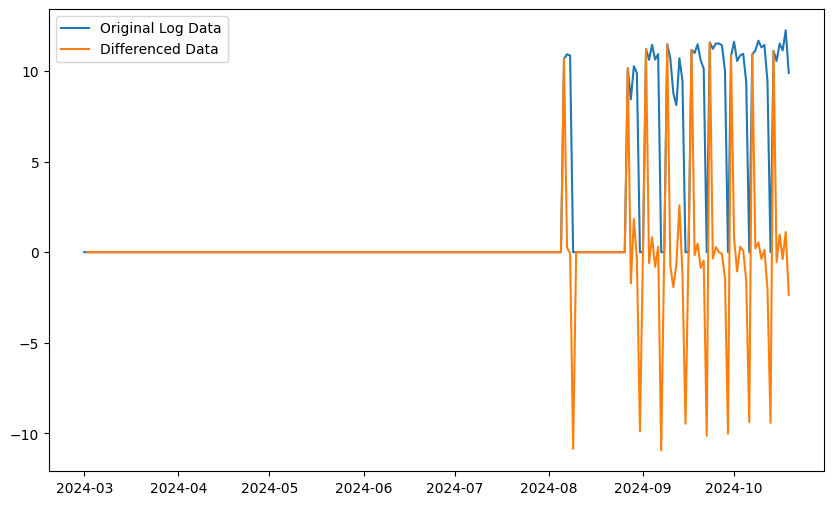

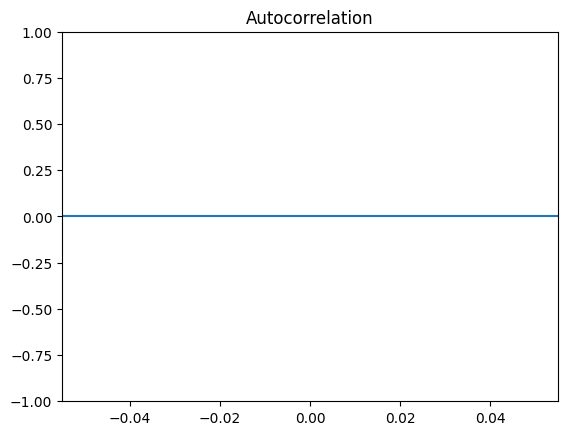

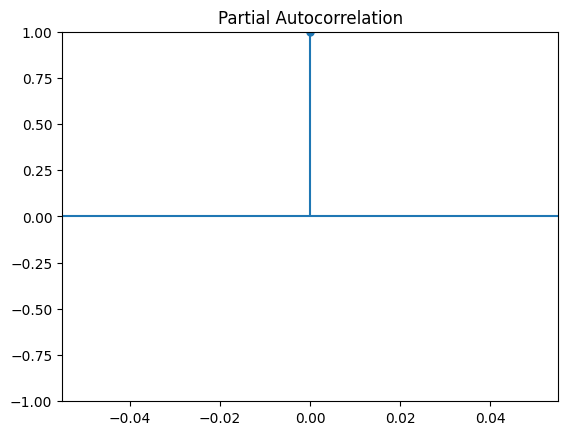

In [94]:
# Check if data are stationary, since SARIMA works with stationary data
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    # Drop NaN values before performing the test
    timeseries = timeseries.dropna()  # Drop NaN values
    if len(timeseries) > 0: # Added this condition to avoid error if timeseries is empty
        result = adfuller(timeseries)
        p_value = result[1]
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {p_value}')
        print('Stationary' if p_value < 0.05 else 'Non-Stationary')
    else:
        print("Timeseries is empty after dropping NaN values.")


# since the variance is high, use log transformation
feature_extracted['metric_log'] = np.log1p(feature_extracted[metric])
check_stationarity(feature_extracted['metric_log'])

# Differencing to make data stationary
feature_extracted['metric_diff'] = feature_extracted['metric_log'].diff().dropna()
check_stationarity(feature_extracted['metric_diff'])
# Set the time as index
feature_extracted.set_index('time', inplace=True)
feature_extracted = feature_extracted.asfreq('D')

# Plot of differencing
plt.figure(figsize=(10, 6))
plt.plot(feature_extracted['metric_log'], label='Original Log Data')
plt.plot(feature_extracted['metric_diff'], label='Differenced Data')
plt.legend()
plt.show()

# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(feature_extracted['metric_diff'])
plot_pacf(feature_extracted['metric_diff'])
plt.show()


<ipython-input-97-461519ee687a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_extracted['value_scaled'] = scaler.fit_transform(feature_extracted[[metric]])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-108.992, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-82.561, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-93.288, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-106.798, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-84.561, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-110.380, Time=0.83 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-101.746, Time=0.34 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-107.271, Time=3.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-106.076, Time=1.77 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-107.706, Time=0.64 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-109.939, Time=0.72 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-109.712, Time=1.05 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-119.829, Time=0.96 sec
 ARIMA(2,1,3)(0,0,0)[12] in

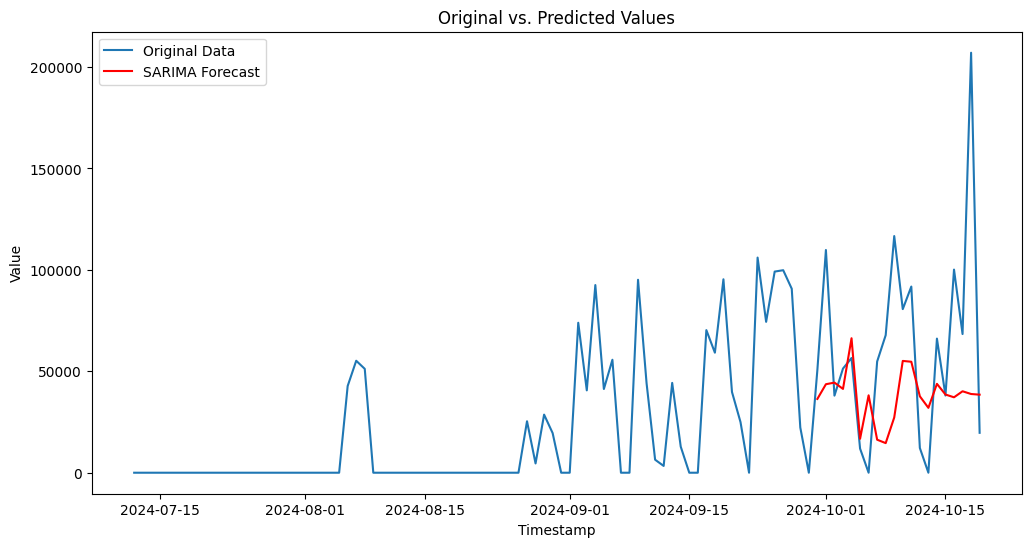

In [97]:

from sklearn.preprocessing import MinMaxScaler

# 1. Data Acquisition and Preprocessing
# Assume you have your data in a pandas DataFrame called 'df' with columns 'timestamp' and 'value'
# df = pd.read_csv('your_data.csv', index_col='timestamp', parse_dates=True)


# 2. Feature Engineering (if needed)
# Add relevant features like lagged values, rolling averages, etc.
# df['lag_1'] = df['value'].shift(1)
feature_extracted = feature_extracted.tail(100)
# 3. Data Scaling
scaler = MinMaxScaler()
feature_extracted['value_scaled'] = scaler.fit_transform(feature_extracted[[metric]])

# 4. Train-Test Split
train_size = int(len(feature_extracted) * 0.8)
train_data = feature_extracted['value_scaled'][:train_size]
test_data = feature_extracted['value_scaled'][train_size:]

# 5. SARIMA Model Selection and Training
# Use auto_arima to find optimal model parameters
auto_model = auto_arima(train_data, seasonal=True, m=12,
                        trace=True, stepwise=True,
                        suppress_warnings=True)
# Get the summary of the best model
print(auto_model.summary())

# Train the SARIMA model
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order
model = SARIMAX(train_data, order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# 6. Prediction and Evaluation
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Inverse scaling to get predictions in original scale
forecast_original_scale = scaler.inverse_transform(forecast_values.values.reshape(-1, 1))[:, 0]

# Evaluate model performance
mse = mean_squared_error(test_data, forecast_values)
print(f"Mean Squared Error (MSE): {mse}")

# 7. Integration with Industry 5.0 Systems
# This part depends on your specific use case.
# You can:
#   - Store the model and use it for real-time predictions.
#   - Integrate the predictions with a digital twin for simulation and optimization.
#   - Trigger actions based on the predictions (e.g., adjusting machine parameters).

# Example: Print the forecast
print("Forecast:")
print(forecast_original_scale)

# 8. Plotting Original vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(feature_extracted.index, feature_extracted[metric], label='Original Data')  # Plot original data
plt.plot(test_data.index, forecast_original_scale, label='SARIMA Forecast', color='red')  # Plot forecast
plt.title('Original vs. Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-99.837, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-90.379, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-94.358, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-99.575, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-92.173, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-101.743, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=-99.759, Time=0.92 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-101.698, Time=2.53 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=-97.253, Time=2.57 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=-102.930, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=-100.829, Time=0.66 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=-96.027, Time=0.81 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=-102.872,

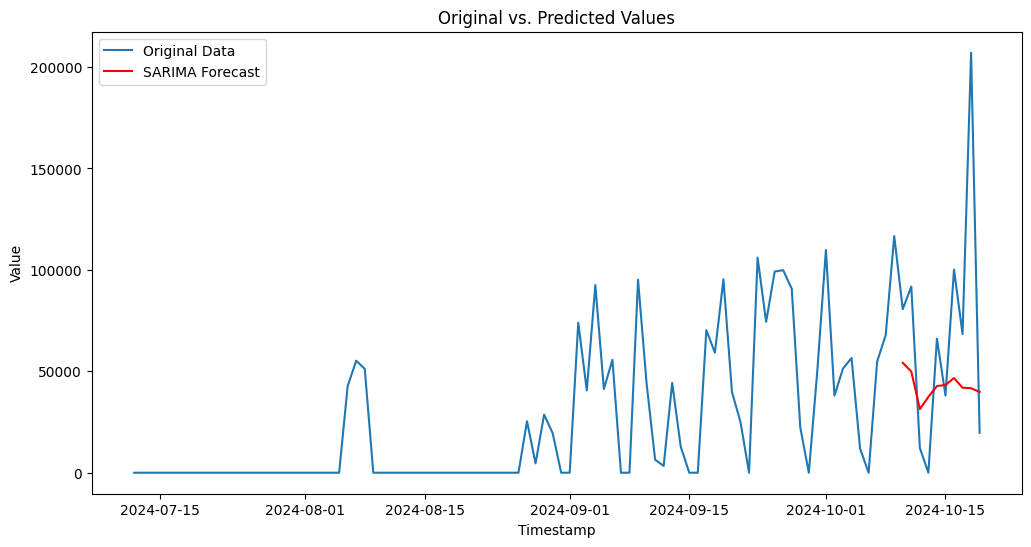

In [99]:



# 1. Data Acquisition and Preprocessing
# ... (Assume you have your data in 'feature_extracted' DataFrame)

# 2. Take the last 100 values
feature_extracted = feature_extracted.tail(100)

# 3. Feature Engineering (if needed)
# ... (Add relevant features if necessary)

# 4. Data Scaling
scaler = MinMaxScaler()
feature_extracted['value_scaled'] = scaler.fit_transform(feature_extracted[[metric]])

# 5. Train-Validation-Test Split
# Calculate split indices
total_len = len(feature_extracted)
train_end = int(total_len * 0.7)  # 70% for training
validation_end = int(total_len * 0.9)  # 20% for validation, 10% for testing


# Split the data
train_data = feature_extracted['value_scaled'][:train_end]
validation_data = feature_extracted['value_scaled'][train_end:validation_end]
test_data = feature_extracted['value_scaled'][validation_end:]

# 6. SARIMA Model Selection and Training using Training and Validation Data
# Use auto_arima to find optimal model parameters with training data
auto_model = auto_arima(train_data, seasonal=True, m=7,  # Set m to 7 for daily data with weekly seasonality
                        trace=True, stepwise=True,
                        suppress_warnings=True)

# Get the summary of the best model
print(auto_model.summary())

# Train the SARIMA model with training data
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order
model = SARIMAX(train_data, order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Validate the model with validation data
# Make predictions on validation data
forecast_steps_validation = len(validation_data)
forecast_validation = results.get_forecast(steps=forecast_steps_validation)
forecast_values_validation = forecast_validation.predicted_mean

# Inverse scaling for validation predictions
forecast_original_scale_validation = scaler.inverse_transform(forecast_values_validation.values.reshape(-1, 1))[:, 0]

# Evaluate model performance on validation data
mse_validation = mean_squared_error(validation_data, forecast_values_validation)
print(f"Validation Mean Squared Error (MSE): {mse_validation}")


# 7. Final Evaluation on Test Data
# Make predictions on test data using the trained model
forecast_steps_test = len(test_data)
forecast_test = results.get_forecast(steps=forecast_steps_test)
forecast_values_test = forecast_test.predicted_mean

# Inverse scaling for test predictions
forecast_original_scale_test = scaler.inverse_transform(forecast_values_test.values.reshape(-1, 1))[:, 0]

# Evaluate model performance on test data
mse_test = mean_squared_error(test_data, forecast_values_test)
print(f"Test Mean Squared Error (MSE): {mse_test}")

# 6. Prediction and Evaluation
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# 7. Integration with Industry 5.0 Systems
# This part depends on your specific use case.
# You can:
#   - Store the model and use it for real-time predictions.
#   - Integrate the predictions with a digital twin for simulation and optimization.
#   - Trigger actions based on the predictions (e.g., adjusting machine parameters).

# Example: Print the forecast
print("Forecast:")
print(forecast_original_scale)

# 8. Plotting Original vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(feature_extracted.index, feature_extracted[metric], label='Original Data')  # Plot original data
plt.plot(test_data.index, forecast_original_scale_test, label='SARIMA Forecast', color='red')  # Plot forecast using forecast_original_scale_test
plt.title('Original vs. Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()


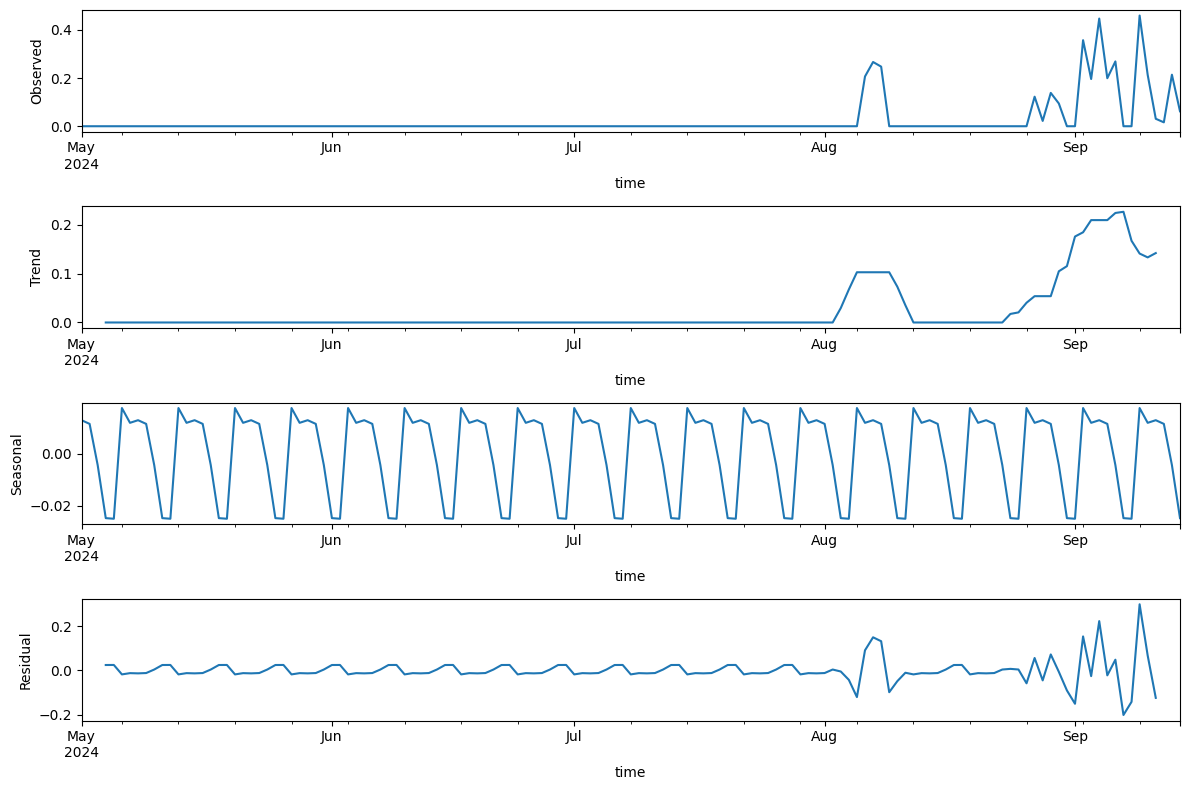

In [85]:
!pip install statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Decompose the time series (assuming it's in a DataFrame named 'df')
decomposition = sm.tsa.seasonal_decompose(train_data, model='additive', period=7) # Set period to expected seasonal length (e.g., 7 for weekly)

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()